In [1]:
from __future__ import annotations
import csv
import json
from dataclasses import dataclass
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt

def find_repo_root(start: Path | None = None) -> Path:
    """Walk upward until Cargo.toml is found to anchor relative paths."""
    current = (start or Path.cwd()).resolve()
    for candidate in [current, *current.parents]:
        if (candidate / "Cargo.toml").exists():
            return candidate
    raise RuntimeError("Could not locate repository root (missing Cargo.toml)")


REPO_ROOT = find_repo_root()
EVAL_DIR = REPO_ROOT / "python" / "evaluation"
REFERENCE_DIR = EVAL_DIR / "reference-data"

@dataclass
class BandData:
    distances: List[float]
    bands: List[List[float]]
    k_nodes: List[dict]

def load_mpb(path: Path) -> BandData:
    data = json.loads(path.read_text())
    distances = [kp["distance"] for kp in data["k_path"]]
    bands = [list(band) for band in zip(*data["bands"])]
    return BandData(distances, bands, data.get("k_nodes", []))

def load_mpb2d_csv(path: Path) -> BandData:
    with path.open() as handle:
        reader = csv.DictReader(handle)
        distances: List[float] = []
        band_columns = [name for name in reader.fieldnames if name.startswith("band")]
        bands = [[] for _ in band_columns]
        for row in reader:
            distances.append(float(row["k_distance"]))
            for idx, column in enumerate(band_columns):
                value = row[column]
                bands[idx].append(float(value) if value else float("nan"))
    return BandData(distances, bands, [])

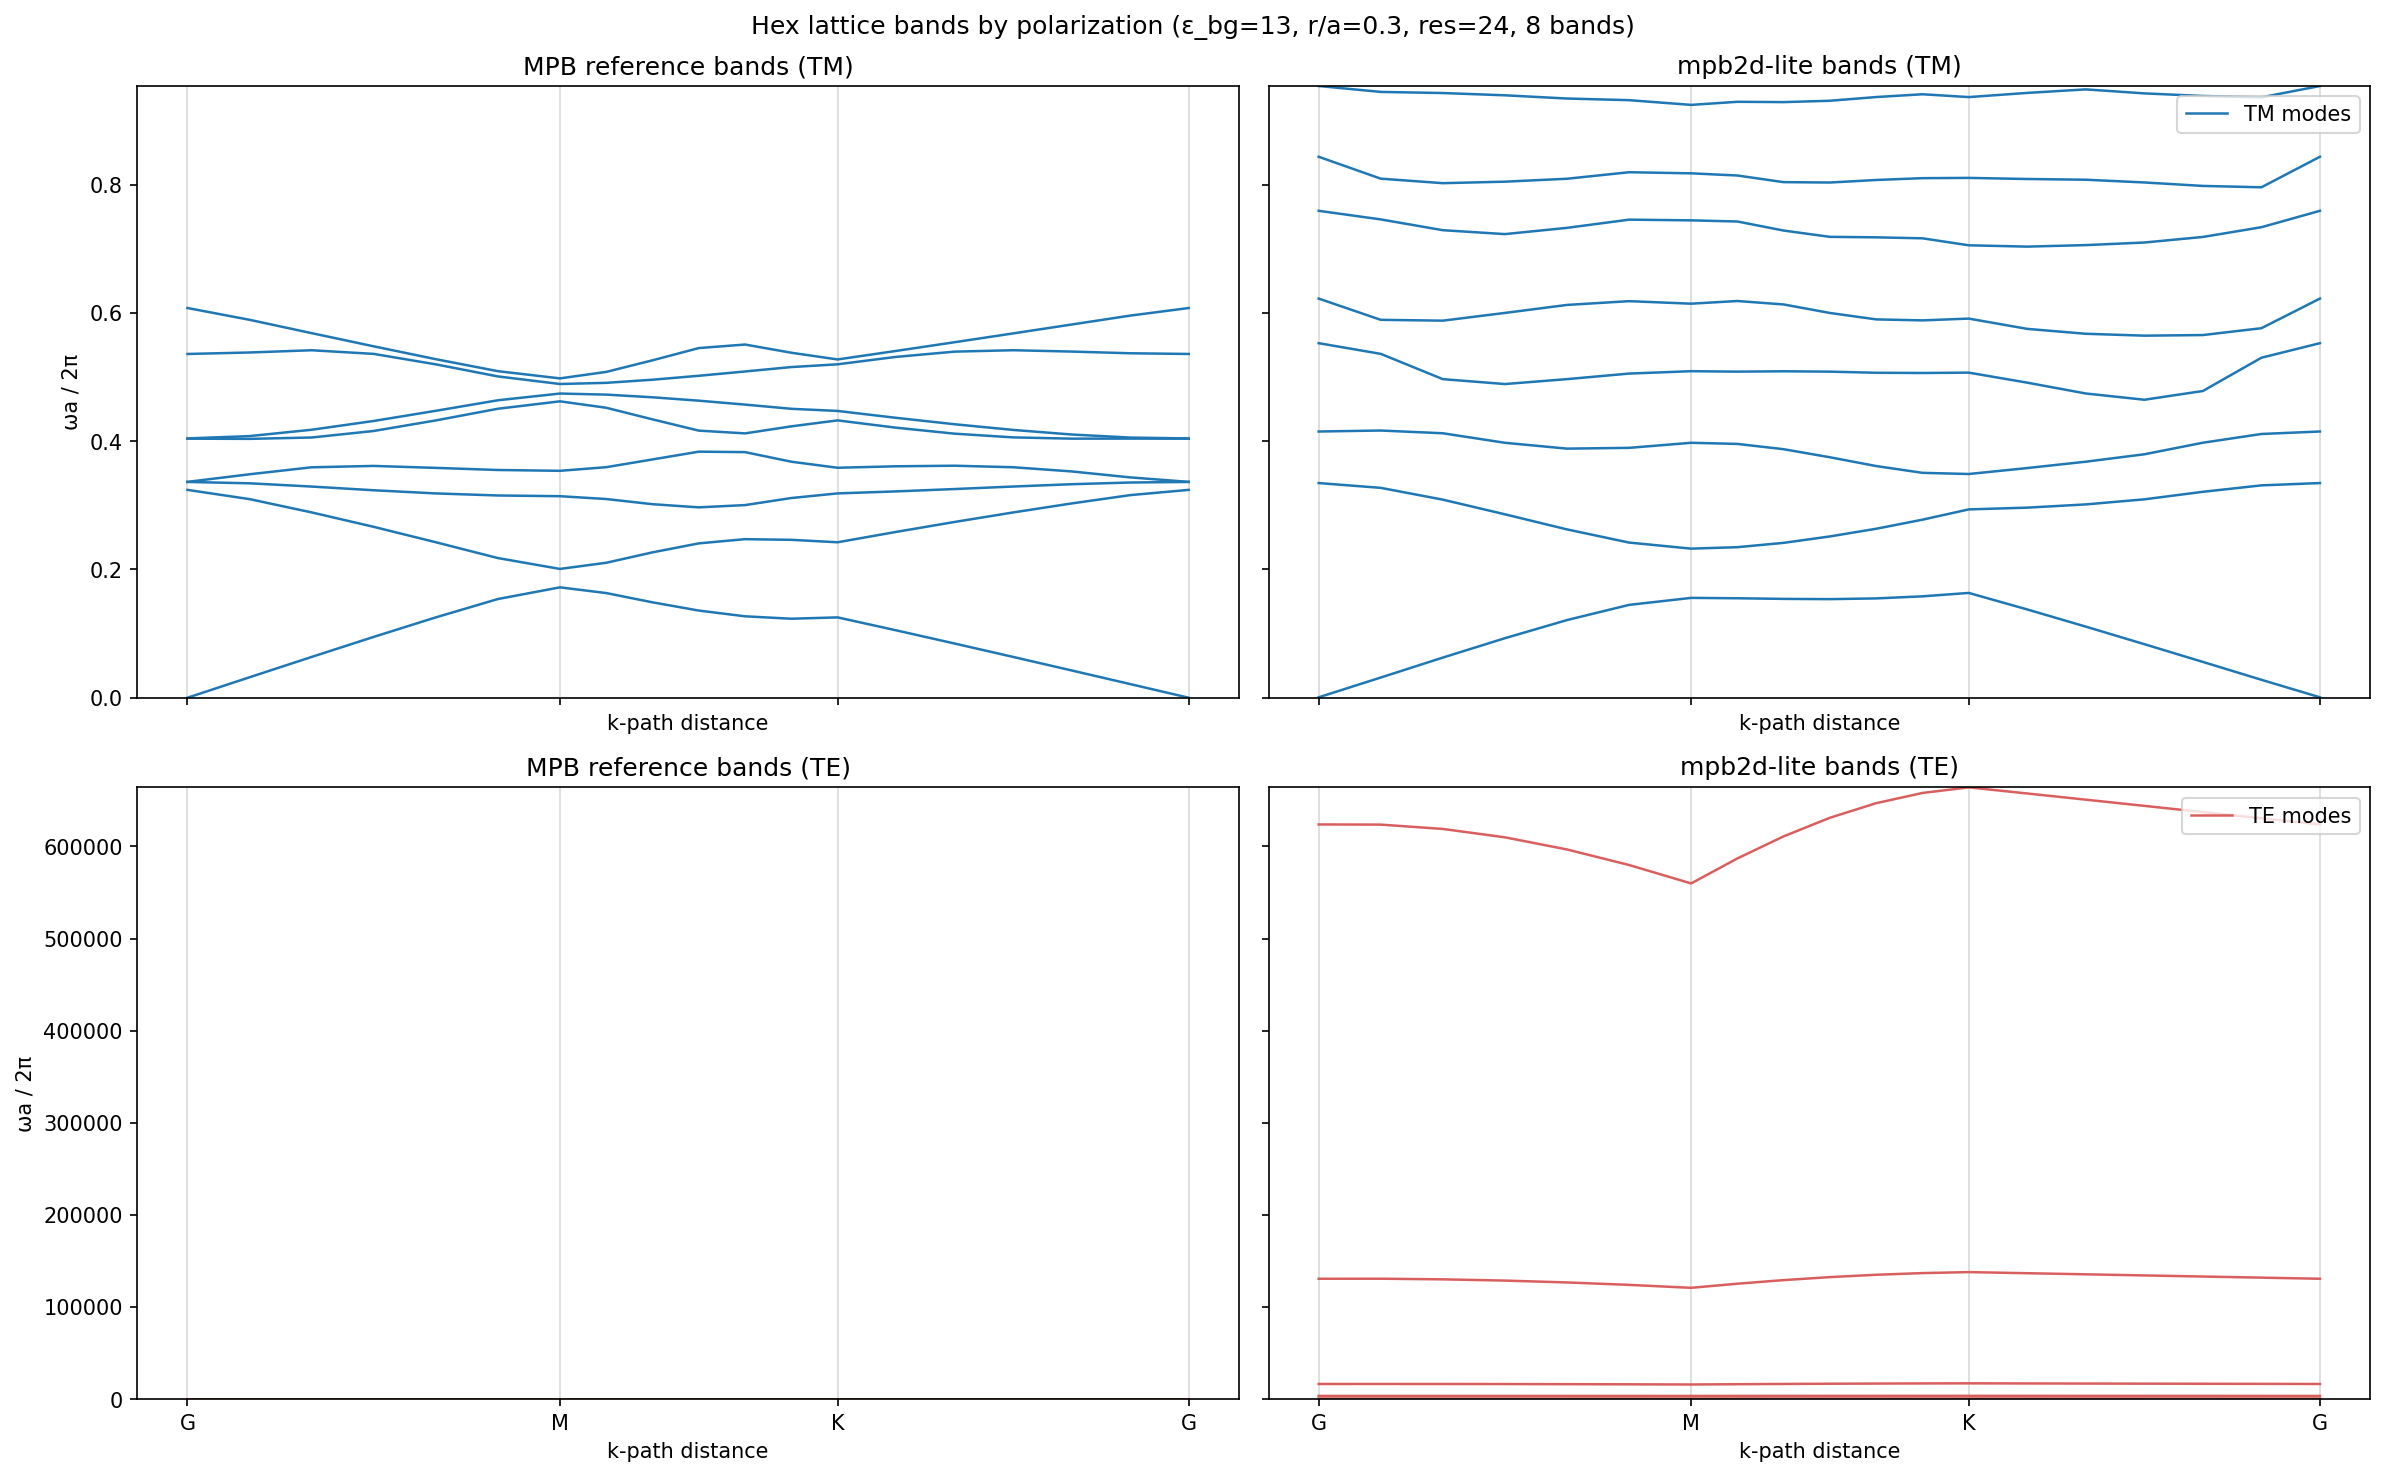

In [4]:
pol_order = ["TM", "TE"]
dataset_order = ["mpb", "mpb2d"]

fig, axes = plt.subplots(
    2,
    2,
    figsize=(16, 10),
    sharex=True,
    sharey="row",
    dpi=150,
)

row_limits = {pol: [float("inf"), float("-inf")] for pol in pol_order}

for row_idx, pol in enumerate(pol_order):
    for col_idx, dataset in enumerate(dataset_order):
        ax = axes[row_idx, col_idx]
        data = load_dataset(dataset, pol)

        for band_idx, band in enumerate(data.bands):
            label = f"{pol} modes" if band_idx == 0 else None
            ax.plot(
                data.distances,
                band,
                color=POL_COLORS[pol],
                linewidth=1.2,
                label=label,
            )

            finite_vals = [value for value in band if not (value != value)]
            if finite_vals:
                row_limits[pol][0] = min(row_limits[pol][0], min(finite_vals))
                row_limits[pol][1] = max(row_limits[pol][1], max(finite_vals))

        if node_positions:
            ax.set_xticks(node_positions)
            ax.set_xticklabels(node_labels)
            for pos in node_positions:
                ax.axvline(pos, color="0.85", linewidth=0.8, zorder=0)

        ax.set_title(f"{PANEL_TITLES[dataset]} ({pol})")
        ax.set_xlabel("k-path distance")
        if col_idx == 0:
            ax.set_ylabel("ωa / 2π")

    axes[row_idx, 1].legend(loc="upper right")

for row_idx, pol in enumerate(pol_order):
    y_min, y_max = row_limits[pol]
    if y_min < y_max:
        for ax in axes[row_idx]:
            ax.set_ylim(y_min, y_max)

fig.suptitle("Hex lattice bands by polarization (ε_bg=13, r/a=0.3, res=24, 8 bands)")
fig.tight_layout()
plt.show()
